# scVI x CITE-seq

### Loading config

In [1]:
cd ../..

In [15]:
n_epochs_all = None
save_path = 'data/'
show_plot = True
%matplotlib inline

In [3]:
import os

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from scvi.dataset import CbmcDataset
from scvi.models import VAE, VAECITE
from scvi.inference import UnsupervisedTrainer, CiteTrainer, CitePosterior

### Load Dataset

In [4]:
# load dataset 
dataset_total = CbmcDataset(save_path=save_path, additional_genes=600, mode='total')
dataset_umi = CbmcDataset(save_path=save_path, additional_genes=600, mode='umi')

# set hyperparameters 
n_epochs_total = 500
n_epochs_umi = 250
lr=0.001
use_batches=False
use_cuda=False

# ADT library stats
X = dataset_total.adt_expression
log_counts = np.log(X.sum(axis=1))
local_mean = np.mean(log_counts).astype(np.float32)
local_var = np.var(log_counts).astype(np.float32)

File data/cbmc/cbmc_rna.csv.gz already downloaded
File data/cbmc/cbmc_adt.csv.gz already downloaded
File data/cbmc/cbmc_adt_centered.csv.gz already downloaded
File data/cbmc/cbmc_clusters.csv.gz already downloaded
Preprocessing cbmc data
Selecting only HUMAN genes (20400 / 36280)
Keeping top 600 genes by variance
Dropping poorly enriched proteins
Finish preprocessing data
File data/cbmc/cbmc_rna.csv.gz already downloaded
File data/cbmc/cbmc_adt.csv.gz already downloaded
File data/cbmc/cbmc_adt_centered.csv.gz already downloaded
File data/cbmc/cbmc_clusters.csv.gz already downloaded
Preprocessing cbmc data
Selecting only HUMAN genes (20400 / 36280)
Keeping top 600 genes by variance
Dropping poorly enriched proteins
Finish preprocessing data


### Initialize and train joint model and model only on genes

In [5]:
# Total Model
vaecite= VAECITE(dataset_total.nb_genes, dataset_total.indexes_adt, adt_mean_lib=local_mean,adt_var_lib=local_var, 
                     reconstruction_loss_adt="nb", n_latent=10, n_labels=dataset_total.n_labels,
                     umi_dispersion='gene', adt_dispersion='protein')

# UMI Model
vae = VAE(dataset_umi.nb_genes, n_batch=0, n_labels=dataset_total.n_labels)

In [6]:
trainer_umi = UnsupervisedTrainer(vae, dataset_umi, train_size=1.0, use_cuda=use_cuda)
trainer_umi.train(n_epochs=n_epochs_umi, lr=lr)

training: 100%|██████████| 250/250 [08:15<00:00,  1.97s/it]


In [7]:
trainer_total = CiteTrainer(vaecite, dataset_total, train_size=1.0, use_cuda=use_cuda)
trainer_total.train(n_epochs=n_epochs_total, lr=lr)

training: 100%|██████████| 500/500 [17:54<00:00,  2.24s/it]


### Compare tsne embeddings and inspect CD8 protein expression for both models

In [8]:
full_posterior_umi = CitePosterior(vae, dataset_umi, use_cuda=False)
full_posterior_total = CitePosterior(vaecite, dataset_total, use_cuda=False)

In [9]:
# Proteins are the last columns of the expression dataset, CD8 is the -8 column
print(dataset_total.protein_markers)
CD8_index = np.where(dataset_total.protein_markers == 'CD8')[0][0] - len(dataset_total.protein_markers)
print(CD8_index)

['CD3' 'CD4' 'CD8' 'CD45RA' 'CD56' 'CD16' 'CD11c' 'CD14' 'CD19' 'CD34']
-8


### Regular VAE

In [18]:
latent, batch_indices, labels = full_posterior_umi.get_latent(sample=True)
latent_tsne, idx_t_sne = full_posterior_umi.apply_t_sne(latent, None)

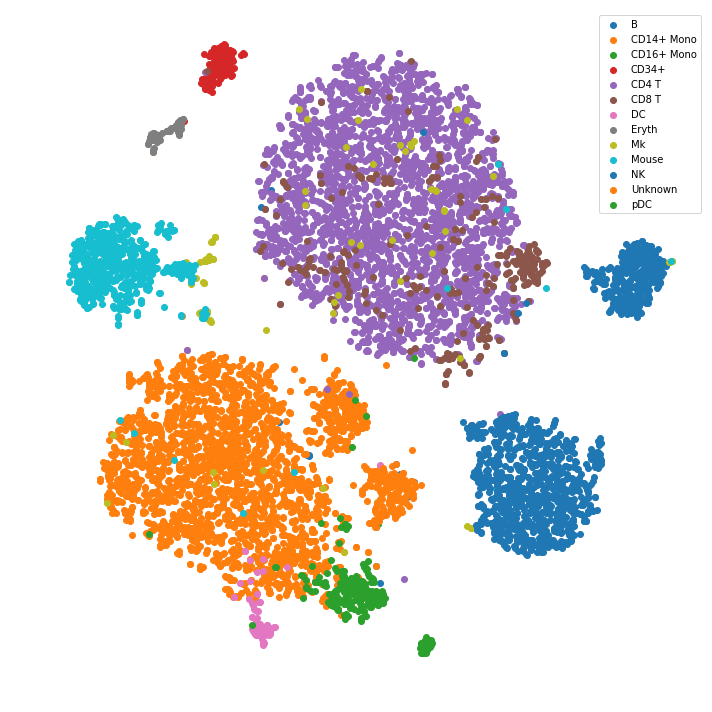

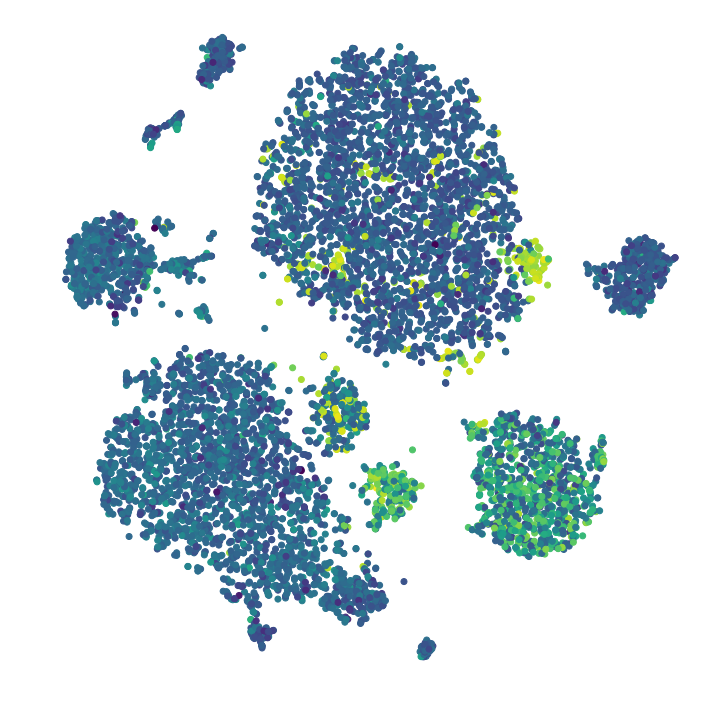

In [19]:
full_posterior_umi.show_t_sne(color_by='labels', n_samples=None, latent=latent_tsne, labels=labels)
# Color by CD8 Protein
cd8 = np.log(dataset_total.X[:,CD8_index])
full_posterior_umi.show_t_sne(color_by='scalar', n_samples=None, latent=latent_tsne, labels=cd8)

### Joint Model

With the joint modeling, CD8 protein levels split the NK cells into CD8 high and CD8 low. CD8 T cells are also more isolated on the tsne embedding.

In [11]:
latent, batch_indices, labels = full_posterior_total.get_latent(sample=True)
latent_tsne, idx_t_sne = full_posterior_total.apply_t_sne(latent, None)

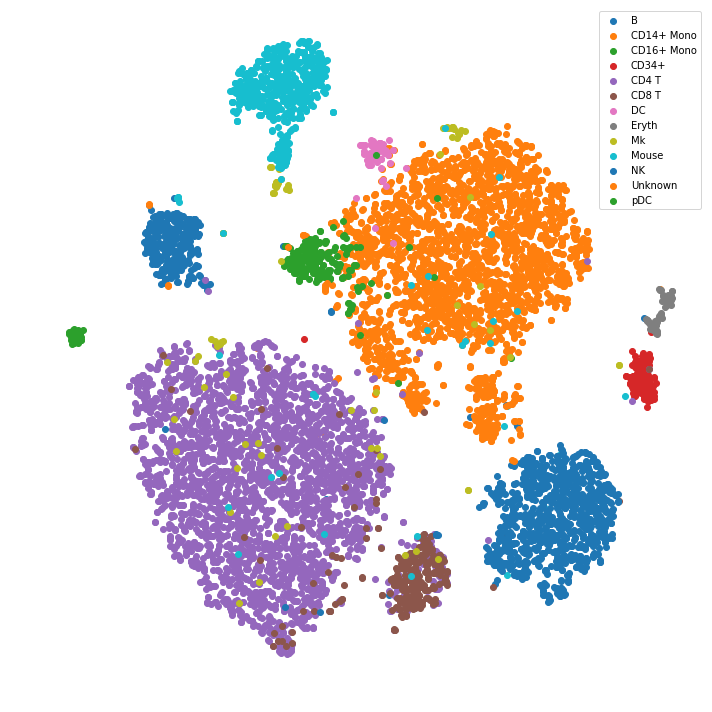

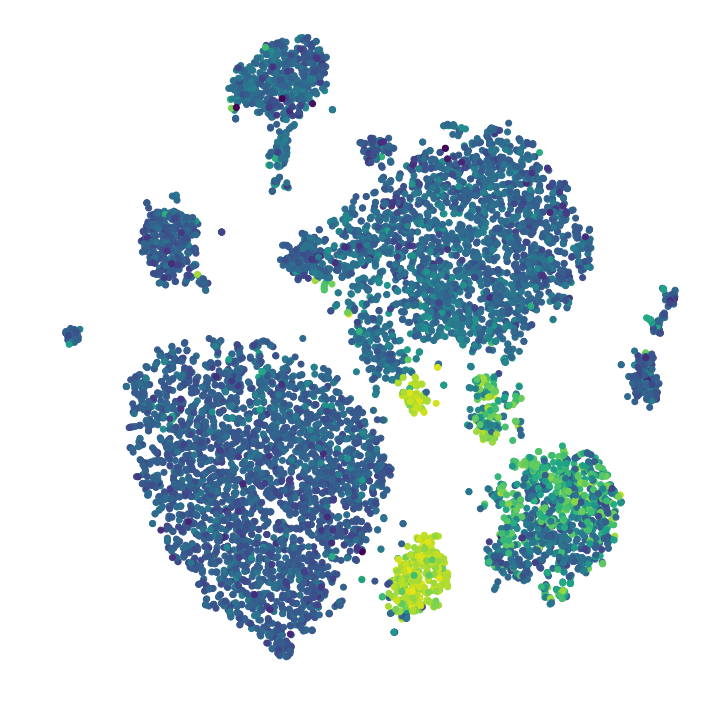

In [17]:
full_posterior_total.show_t_sne(color_by='labels', n_samples=None, latent=latent_tsne, labels=labels)
# Color by CD8 Protein
full_posterior_total.show_t_sne(color_by='scalar', n_samples=None, latent=latent_tsne, labels=cd8)

In [ ]:
def allow_notebook_for_test():
    print("Testing the data loading notebook")